# Surface Temperature  
 
```{glue:figure} trend_fig_max_min
:scale: 50%
:align: right
```

Highlights  

- The Pacific Islands mean temperature over land increased by 1.1°C (2°F) since {glue:text}`start_year:.0f`, whereas in Palau, the records show an increase of {glue:text}`change_mean:.2f` °C from {glue:text}`start_year:.0f` to {glue:text}`end_year:.0f`.

- On the other hand, the minimum temperatures show an increasing trend of {glue:text}`trend_min:.3f` °C/year and the maximum temperatures a non signiticative trend of {glue:text}`trend_max:.3f`, making the variability of temperatures within each day to be decreasing at {glue:text}`trend_diff:.2f` °C/year. 


- The top 10 years on record have occurred since {glue:text}`top_10_year:.0f`. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os.path as op
import sys
import contextlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from myst_nb import glue 

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive, fig_int_to_glue
from ind_setup.plotting import plot_bar_probs, fontsize
from ind_setup.tables import get_data_metrics, plot_df_table

sys.path.append("../../../functions")
from data_downloaders import GHCN

## Define location and variables of interest

In [3]:
country = 'Palau'
vars_interest = ['TMIN', 'TMAX']

## Get Data

In [4]:
update_data = False
path_data = "../../../data"

## Using Koror Station

Analysis of how much the maximum and minimum temperatures over time are changing. <br>
The analysis of the difference between these 2 variables will allow us to know how the daily variability is being modified

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

In [5]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

In [6]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_min = GHCN.extract_dict_data_var(GHCND_dir, 'TMIN', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    dict_max = GHCN.extract_dict_data_var(GHCND_dir, 'TMAX', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    st_data = pd.concat([dict_min['data'], (dict_max['data'])], axis=1).dropna()
    st_data['diff'] = st_data['TMAX'] - st_data['TMIN']
    st_data['TMEAN'] = (st_data['TMAX'] + st_data['TMIN'])/2
    st_data.to_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))
else:
    st_data = pd.read_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))

In [7]:
st_data = st_data.resample('Y').mean()
glue("n_years", len(np.unique(st_data.index.year)), display=False)
glue("start_year", st_data.dropna().index[0].year, display=False)
glue("end_year", st_data.dropna().index[-1].year, display=False)

### Mean temperature

In [8]:
dict_plot = [{'data' : st_data, 'var' : 'TMEAN', 'ax' : 1, 'label' : 'TMEAN'},
        ]

In [9]:
dict_plot = [{'data' : st_data, 'var' : 'TMEAN', 'ax' : 1, 'label' : 'TMEAN'}]
fig = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12))

glue("trend_fig_mean", fig_int_to_glue(fig), display=False)


**Fig.** Annual maxima corresponding to the mean temperature.

In [10]:
st_data['TMEAN_ref'] = st_data['TMEAN'] - st_data.loc['1961':'1990'].TMEAN.mean()

In [11]:
# import matplotlib.pyplot as plt
# plot_bar_probs(x = st_data.index.year, y = st_data.TMEAN_ref, trendline = True, figsize = [15, 4])
# plt.title('Temperature anomalies (Over and above 1961 - 1990 reference period)', fontsize = 15);

In [12]:
nevents = 10
top_10 = st_data.sort_values(by='TMEAN_ref', ascending=False).head(nevents)

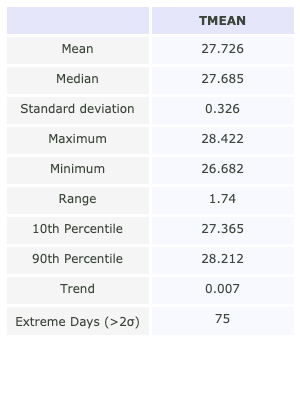

In [13]:
from ind_setup.tables import plot_df_table

var = 'TMEAN'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))

In [14]:
st_data

,TMIN,TMAX,diff,TMEAN,TMEAN_ref
DATE,,,,,
1951-12-31,24.150543,30.924457,6.773913,27.537500,-0.069683
1952-12-31,23.837978,30.904645,7.066667,27.371311,-0.235871
1953-12-31,24.088767,31.039726,6.950959,27.564247,-0.042936
1954-12-31,25.000548,31.084384,6.083836,28.042466,0.435283
1955-12-31,23.756986,30.741918,6.984932,27.249452,-0.357731
...,...,...,...,...,...
2021-12-31,24.745042,28.618414,3.873371,26.681728,-0.925455
2022-12-31,24.541781,29.917466,5.375685,27.229623,-0.377560
2023-12-31,25.518440,30.079787,4.561348,27.799113,0.191931


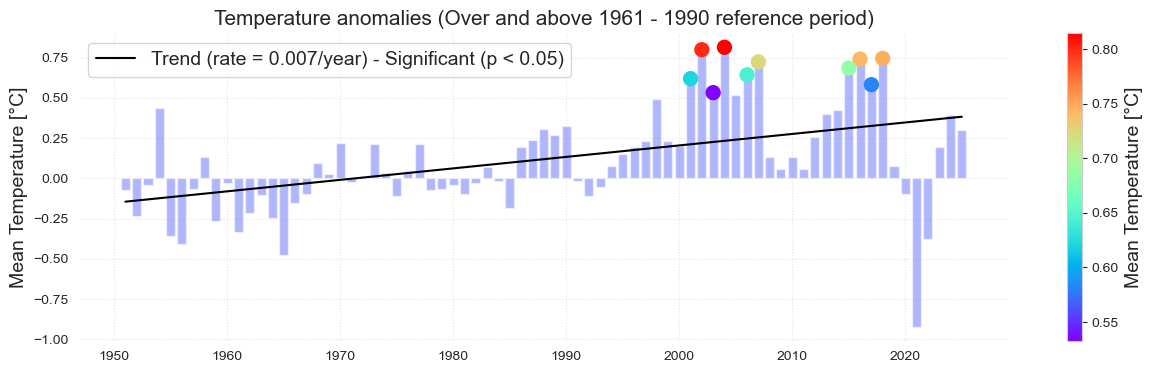

In [15]:
fig, ax, trend = plot_bar_probs(x=st_data.index.year, y=st_data.TMEAN_ref, trendline=True,
                                y_label='Mean Temperature [°C]', figsize=[15, 4], return_trend=True)

glue("trend_mean", float(trend), display=False)
glue("change_mean", float(trend * len(np.unique(st_data.index.year))), display=False)
glue("top_10_year", float(top_10.sort_index().index.year[0]), display=False)

im = ax.scatter(top_10.index.year, top_10.TMEAN_ref, 
                c=top_10.TMEAN_ref.values, s=100, cmap='rainbow', label='Top 10 warmest years')
plt.title('Temperature anomalies (Over and above 1961 - 1990 reference period)', fontsize=15)
plt.colorbar(im).set_label('Mean Temperature [°C]', fontsize=fontsize)
glue("trend_fig", fig, display=False)


```{glue:figure} trend_fig
:name: "trend_fig_ST_10"

Annomaly of the mean temperature over and above the 1961-1990 reference period. Overlapping points correspond to the top 10 warmer years.

```

## Minimum and Maximum Temperatures

In [16]:
dict_plot = [{'data' : st_data, 'var' : 'TMIN', 'ax' : 1, 'label' : 'TMIN'},
        {'data' : st_data, 'var' : 'TMAX', 'ax' : 2, 'label' : 'TMAX'},
        # {'data' : st_data, 'var' : 'diff', 'ax' : 1, 'label' : 'Difference TMAX - TMIN'}
        ]

In [18]:
fig, TRENDS = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (24, 11), return_trend = True)
fig.write_html(op.join(path_data, 'figures', 'F3_ST_min_max.html'), include_plotlyjs="cdn")

glue("trend_min", float(TRENDS[0]), display=False)
glue("trend_max", float(TRENDS[1]), display=False)

glue("change_min", float(TRENDS[0]*len(np.unique(st_data.index.year))), display=False)
glue("change_max", float(TRENDS[1]*len(np.unique(st_data.index.year))), display=False)

glue("trend_fig_max_min", fig_int_to_glue(fig), display=False)

**Fig.** Annual maximum (red) and minimum (blue) temperature at Koror. The solid black line represents the trend, which is  statistically significant (p < 0.05).  The dashed black line represents a trend that is not statistically significant.  

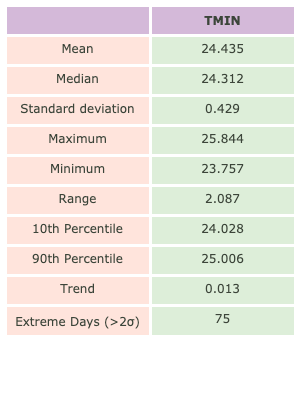

In [18]:
var = 'TMIN'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))

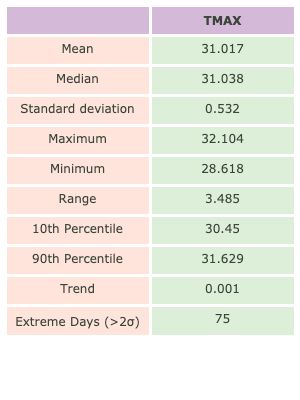

In [19]:
var = 'TMAX'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))

## Difference temperature

In [20]:
dict_plot = [{'data' : st_data, 'var' : 'diff', 'ax' : 1, 'label' : 'Difference TMAX - TMIN'}]
fig, trend = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12), return_trend = True)
glue("trend_diff", float(trend[0]), display=False)


**Fig.** Annual maximum of the difference of the maximum and minimum temperature within each day

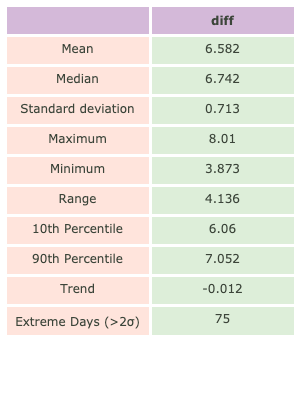

In [21]:

var = 'diff'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))